<a href="https://colab.research.google.com/github/Rachit1811/stock-market-lstm-varmax/blob/main/AirBnb_optimal_log_price_prediction%2C_boosting_algos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, accuracy_score
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import joblib
pd.set_option("display.max_colwidth", None)

In [45]:
usecols = [
    "log_price",
    "property_type",
    "room_type",
    "accommodates",
    "amenities",
    "bathrooms",
    "bed_type",
    'host_response_rate',
    'host_has_profile_pic',
    'host_identity_verified',
    "cancellation_policy",
    "cleaning_fee",
    "city",
    "instant_bookable",
    "host_has_profile_pic",
    "host_identity_verified",
    "latitude",
    "longitude",
    "name",
    "neighbourhood",
    "number_of_reviews",
    "bedrooms",
    "beds",

]

In [46]:
df = pd.read_excel("/Airbnb_Data.xlsx", usecols=usecols)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   log_price               74111 non-null  float64
 1   property_type           74111 non-null  object 
 2   room_type               74111 non-null  object 
 3   amenities               74111 non-null  object 
 4   accommodates            74111 non-null  int64  
 5   bathrooms               73911 non-null  float64
 6   bed_type                74111 non-null  object 
 7   cancellation_policy     74111 non-null  object 
 8   cleaning_fee            74111 non-null  bool   
 9   city                    74111 non-null  object 
 10  host_has_profile_pic    73923 non-null  object 
 11  host_identity_verified  73923 non-null  object 
 12  host_response_rate      55812 non-null  float64
 13  instant_bookable        74111 non-null  object 
 14  latitude                74111 non-null

In [48]:
df.isna().sum()

log_price                     0
property_type                 0
room_type                     0
amenities                     0
accommodates                  0
bathrooms                   200
bed_type                      0
cancellation_policy           0
cleaning_fee                  0
city                          0
host_has_profile_pic        188
host_identity_verified      188
host_response_rate        18299
instant_bookable              0
latitude                      0
longitude                     0
name                         10
neighbourhood              6872
number_of_reviews             0
bedrooms                     91
beds                        131
dtype: int64

In [49]:
df.dropna(subset=['bathrooms', 'host_has_profile_pic', 'host_identity_verified', 'bedrooms', 'beds'], inplace=True)
df.isna().sum()

log_price                     0
property_type                 0
room_type                     0
amenities                     0
accommodates                  0
bathrooms                     0
bed_type                      0
cancellation_policy           0
cleaning_fee                  0
city                          0
host_has_profile_pic          0
host_identity_verified        0
host_response_rate        18021
instant_bookable              0
latitude                      0
longitude                     0
name                         10
neighbourhood              6844
number_of_reviews             0
bedrooms                      0
beds                          0
dtype: int64

## Data Cleaning and Feauture Creation

In [50]:
df["instant_bookable"] = df["instant_bookable"].map({"t": True, "f": False})
df["host_has_profile_pic"] = df["host_has_profile_pic"].map({"t": True, "f": False})
df["host_identity_verified"] = df["host_identity_verified"].map({"t": True, "f": False})


In [51]:
df.duplicated().sum()

0

Filling in Null values in the ```df['neighbourhood']``` column using KNN

In [52]:
df_neighbourhood = df[["latitude", "longitude", "neighbourhood"]]

In [53]:
df_neighbourhood.isna().sum()

latitude            0
longitude           0
neighbourhood    6844
dtype: int64

In [54]:
X_test_nbrs = df_neighbourhood.loc[df_neighbourhood["neighbourhood"].isna()].drop(
    "neighbourhood", axis=1
)
df_neighbourhood_not_na = df_neighbourhood.loc[
    ~df_neighbourhood["neighbourhood"].isna()
]
X_train_nbrs, y_train_nbrs = (
    df_neighbourhood_not_na.drop(["neighbourhood"], axis=1),
    df_neighbourhood_not_na["neighbourhood"],
)
nbrs = KNeighborsClassifier(n_neighbors=2)
nbrs.fit(X_train_nbrs, y_train_nbrs)
nbrs_pred = nbrs.predict(X_test_nbrs)
nbrs_pred = pd.Series(nbrs_pred, index=X_test_nbrs.index)
nbrs_pred

6        Marina Del Rey
9           West Covina
14           Long Beach
26            Hollywood
28             Downtown
              ...      
74098         Hollywood
74099         Hollywood
74101      Santa Monica
74104        Gold Coast
74105    West Hollywood
Length: 6844, dtype: object

In [55]:
df["neighbourhood"] = df["neighbourhood"].fillna(value=nbrs_pred)

In [56]:
usecolsforpred = [
    "log_price",
    "accommodates",
    "bathrooms",
    'host_response_rate',
    'host_has_profile_pic',
    'host_identity_verified',
    "cleaning_fee",
    "instant_bookable",
    "latitude",
    "longitude",
    "number_of_reviews",
    "bedrooms",
    "beds",

]

In [57]:
df[usecolsforpred].info()

<class 'pandas.core.frame.DataFrame'>
Index: 73579 entries, 0 to 74110
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   log_price               73579 non-null  float64
 1   accommodates            73579 non-null  int64  
 2   bathrooms               73579 non-null  float64
 3   host_response_rate      55558 non-null  float64
 4   host_has_profile_pic    73579 non-null  bool   
 5   host_identity_verified  73579 non-null  bool   
 6   cleaning_fee            73579 non-null  bool   
 7   instant_bookable        73579 non-null  bool   
 8   latitude                73579 non-null  float64
 9   longitude               73579 non-null  float64
 10  number_of_reviews       73579 non-null  int64  
 11  bedrooms                73579 non-null  float64
 12  beds                    73579 non-null  float64
dtypes: bool(4), float64(7), int64(2)
memory usage: 5.9 MB


In [58]:
df_pred = df[usecolsforpred]

In [59]:
bool_columns = df_pred.select_dtypes(include=['bool']).columns
df_pred[bool_columns] = df_pred[bool_columns].astype(int)
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73579 entries, 0 to 74110
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   log_price               73579 non-null  float64
 1   accommodates            73579 non-null  int64  
 2   bathrooms               73579 non-null  float64
 3   host_response_rate      55558 non-null  float64
 4   host_has_profile_pic    73579 non-null  int64  
 5   host_identity_verified  73579 non-null  int64  
 6   cleaning_fee            73579 non-null  int64  
 7   instant_bookable        73579 non-null  int64  
 8   latitude                73579 non-null  float64
 9   longitude               73579 non-null  float64
 10  number_of_reviews       73579 non-null  int64  
 11  bedrooms                73579 non-null  float64
 12  beds                    73579 non-null  float64
dtypes: float64(7), int64(6)
memory usage: 7.9 MB


<ipython-input-59-c6b60f3f2eed>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [60]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Separate the rows with and without missing host_response_rate
df_with_response_rate = df_pred[df_pred['host_response_rate'].notnull()]
df_missing_response_rate = df_pred[df_pred['host_response_rate'].isnull()]

# Features to use for training the model (excluding the target variable)
features = ['log_price', 'accommodates', 'bathrooms', 'host_has_profile_pic',
            'host_identity_verified', 'cleaning_fee', 'instant_bookable',
            'latitude', 'longitude', 'number_of_reviews', 'bedrooms', 'beds']

# Prepare training data
X_train = df_with_response_rate[features]
y_train = df_with_response_rate['host_response_rate']

# Prepare data to predict
X_missing = df_missing_response_rate[features]

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dmissing = xgb.DMatrix(X_missing)

# Set XGBoost parameters for regression
params = {
    'objective': 'reg:squarederror',  # Regression objective
    'eval_metric': 'rmse',  # Evaluation metric
    'max_depth': 5,  # Maximum depth of trees
    'eta': 0.1,  # Learning rate
    'subsample': 0.8,  # Subsample ratio
    'colsample_bytree': 0.8  # Subsample ratio of columns when constructing each tree
}

# Train XGBoost model
num_rounds = 100  # Number of boosting rounds
bst = xgb.train(params, dtrain, num_rounds)

# Predict missing values
predicted_response_rate = bst.predict(dmissing)

# Fill missing values in the original DataFrame
df.loc[df['host_response_rate'].isnull(), 'host_response_rate'] = predicted_response_rate

# Check the DataFrame info again to ensure missing values are filled
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 73579 entries, 0 to 74110
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   log_price               73579 non-null  float64
 1   property_type           73579 non-null  object 
 2   room_type               73579 non-null  object 
 3   amenities               73579 non-null  object 
 4   accommodates            73579 non-null  int64  
 5   bathrooms               73579 non-null  float64
 6   bed_type                73579 non-null  object 
 7   cancellation_policy     73579 non-null  object 
 8   cleaning_fee            73579 non-null  bool   
 9   city                    73579 non-null  object 
 10  host_has_profile_pic    73579 non-null  bool   
 11  host_identity_verified  73579 non-null  bool   
 12  host_response_rate      73579 non-null  float64
 13  instant_bookable        73579 non-null  bool   
 14  latitude                73579 non-null  flo

Cleaning up the entries in ```df['amenities]``` column

In [61]:
clean_list = lambda clean_list: [
    item.strip('"') for item in clean_list.strip("{}").split(",")
]
df["amenities"] = df["amenities"].apply(clean_list)

In [62]:
df.dropna(inplace=True)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73569 entries, 0 to 74110
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   log_price               73569 non-null  float64
 1   property_type           73569 non-null  object 
 2   room_type               73569 non-null  object 
 3   amenities               73569 non-null  object 
 4   accommodates            73569 non-null  int64  
 5   bathrooms               73569 non-null  float64
 6   bed_type                73569 non-null  object 
 7   cancellation_policy     73569 non-null  object 
 8   cleaning_fee            73569 non-null  bool   
 9   city                    73569 non-null  object 
 10  host_has_profile_pic    73569 non-null  bool   
 11  host_identity_verified  73569 non-null  bool   
 12  host_response_rate      73569 non-null  float64
 13  instant_bookable        73569 non-null  bool   
 14  latitude                73569 non-null  flo

In [64]:
len(df["property_type"].value_counts())

34

If the value count of a certain property type is below a certain threshold it will be renamed to **"Other"** as there are too many property types **(34)** as well as there being too many with extremely low value counts

In [65]:
property_list = list((dict(df["property_type"].value_counts()).keys()))

PROPERTY = []

property_list.reverse()
property_list = list(property_list)

for property_ in property_list:
    df["property_type"] = df["property_type"].replace(property_, "Other")
    if property_ == "Villa":
        break

df["property_type"].value_counts()

property_type
Apartment          48605
House              16423
Condominium         2646
Townhouse           1683
Other               1657
Loft                1236
Guesthouse           497
Bed & Breakfast      457
Bungalow             365
Name: count, dtype: int64

Dropping entries where the value count of the neighbourhood is infrequent

In [66]:
hood_list = list(dict(df["neighbourhood"].value_counts()).keys())

NEIGHBOURHOOD = []

for hood in hood_list:
    NEIGHBOURHOOD.append(hood)
    if hood == "Takoma":
        break

df = df[df["neighbourhood"].isin(NEIGHBOURHOOD)].reset_index().drop("index", axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70710 entries, 0 to 70709
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   log_price               70710 non-null  float64
 1   property_type           70710 non-null  object 
 2   room_type               70710 non-null  object 
 3   amenities               70710 non-null  object 
 4   accommodates            70710 non-null  int64  
 5   bathrooms               70710 non-null  float64
 6   bed_type                70710 non-null  object 
 7   cancellation_policy     70710 non-null  object 
 8   cleaning_fee            70710 non-null  bool   
 9   city                    70710 non-null  object 
 10  host_has_profile_pic    70710 non-null  bool   
 11  host_identity_verified  70710 non-null  bool   
 12  host_response_rate      70710 non-null  float64
 13  instant_bookable        70710 non-null  bool   
 14  latitude                70710 non-null

Feature Creation


In [67]:
df["has_internet"] = df["amenities"].apply(
    lambda amenities_list: any(
        item in amenities_list for item in ["Wireless Internet", "Internet"]
    )
)

df["has_air_conditioning"] = df["amenities"].apply(
    lambda amenities_list: "Air conditioning" in amenities_list
)

df["has_kitchen"] = df["amenities"].apply(
    lambda amenities_list: "Kitchen" in amenities_list
)

df["has_cable_tv"] = df["amenities"].apply(
    lambda amenities_list: any(item in amenities_list for item in ["TV", "Cable TV"])
)

df["has_luxuries"] = df["amenities"].apply(
    lambda amenities_list: any(
        item in amenities_list for item in ["Gym", "Hot tub", "Pool"]
    )
)

In [68]:
df_bool = df.select_dtypes(np.bool_)
df_categorical = df.select_dtypes(include=[np.bool_, object])
df_numerical = df.select_dtypes(include=np.number)

df_non_categorical = pd.concat([df_numerical, df_bool], axis=1)

## Data Visualization and insights

<ipython-input-69-2bd9c8cef933>:13: UserWarning:

FixedFormatter should only be used together with FixedLocator



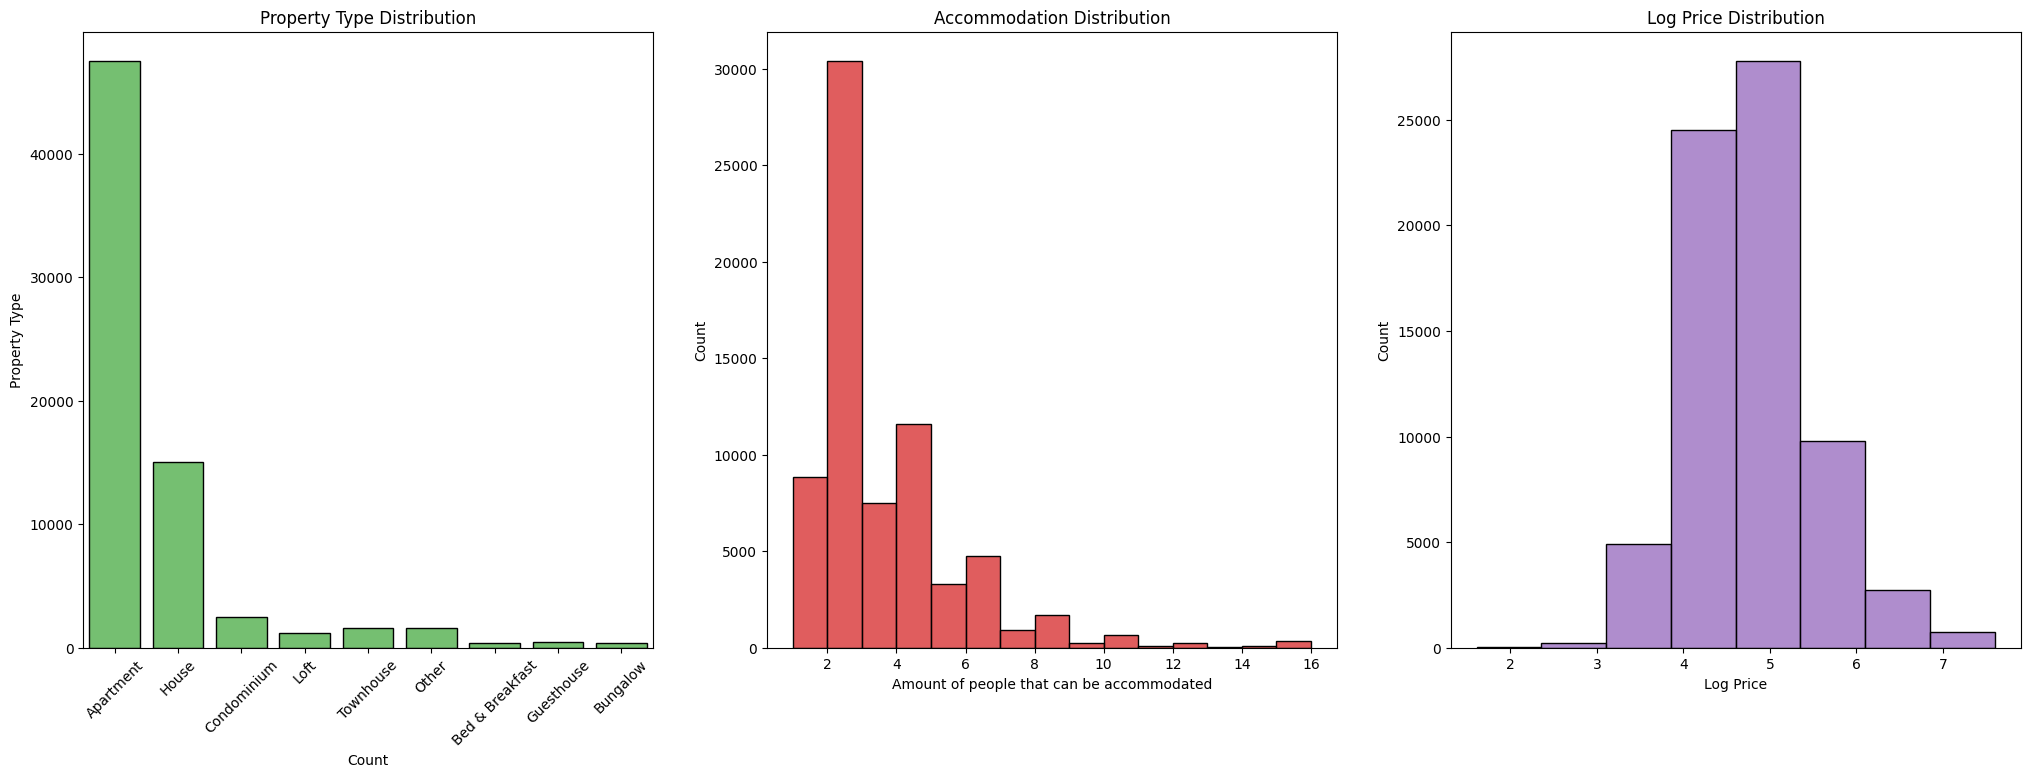

In [69]:
fig, ax = plt.subplots(1, 3, figsize=(25, 8))

sns.countplot(
    x="property_type",
    data=df,
    color=sns.color_palette("muted")[2],
    edgecolor="black",
    ax=ax[0],
)
ax[0].set_title("Property Type Distribution")
ax[0].set_ylabel("Property Type")
ax[0].set_xlabel("Count")
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)


sns.histplot(
    x="accommodates", data=df, binwidth=1, color=sns.color_palette()[3], ax=ax[1]
)
ax[1].set_title("Accommodation Distribution")
ax[1].set_xlabel("Amount of people that can be accommodated")
ax[1].set_ylabel("Count")


sns.histplot(
    data=df,
    x="log_price",
    edgecolor="black",
    bins=8,
    ax=ax[2],
    color=sns.color_palette()[4],
)
ax[2].set_title("Log Price Distribution")
ax[2].set_xlabel("Log Price")
ax[2].set_ylabel("Count")

plt.show()

Insights
+ Most common type of AirBnb is an apartment
+ Most AirBnb's accomodate not many people usually 2 to 3
+ Most AirBnb's are priced from fair to slighty expensive

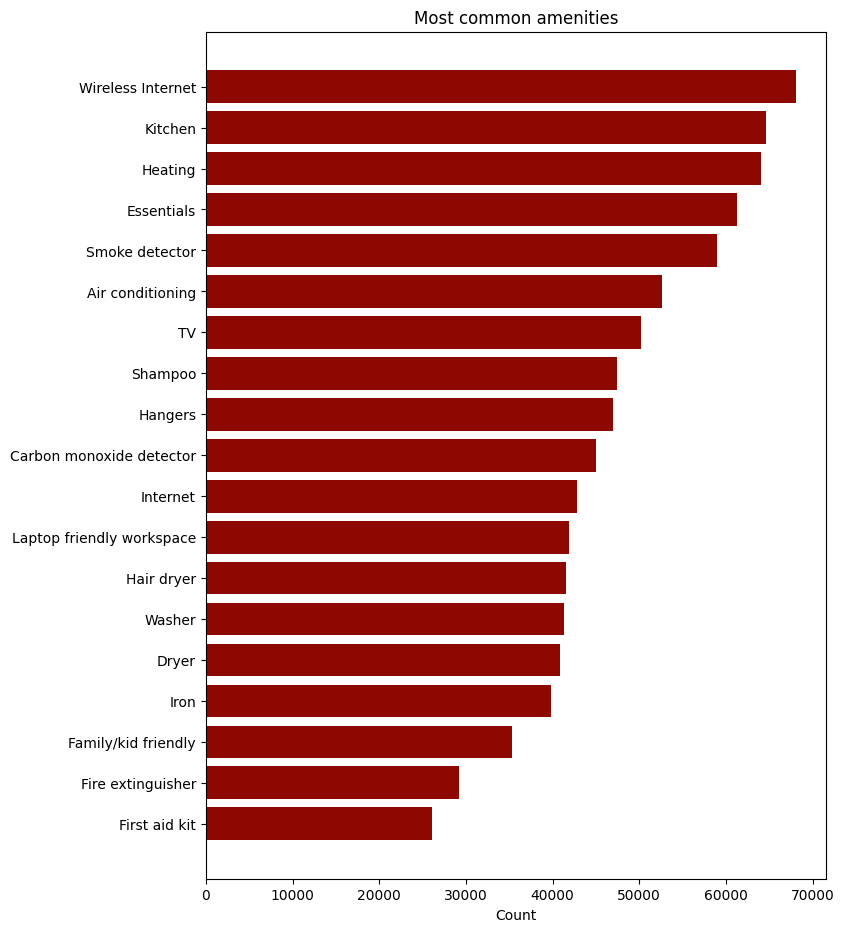

In [70]:
amenities_count = [item for sublist in df["amenities"] for item in sublist]
amenities_count = Counter(amenities_count)
df_amenities = (
    pd.DataFrame.from_dict(amenities_count, orient="index", columns=["Count"])
    .reset_index()
    .rename({"index": "Amenity"}, axis=1)
    .sort_values(by="Count", ascending=False)
)

NUM_COL = 19
colour = sns.color_palette(palette="dark")[3]

plt.figure(figsize=(8, 11))
plt.barh(
    y=df_amenities["Amenity"].head(NUM_COL),
    width=df_amenities["Count"].head(NUM_COL),
    color=colour,
)
plt.title("Most common amenities")
plt.xlabel("Count")
plt.gca().invert_yaxis()

plt.show()

Insights
+ Most common amenity in a AirBnb is by far Wireless Internet

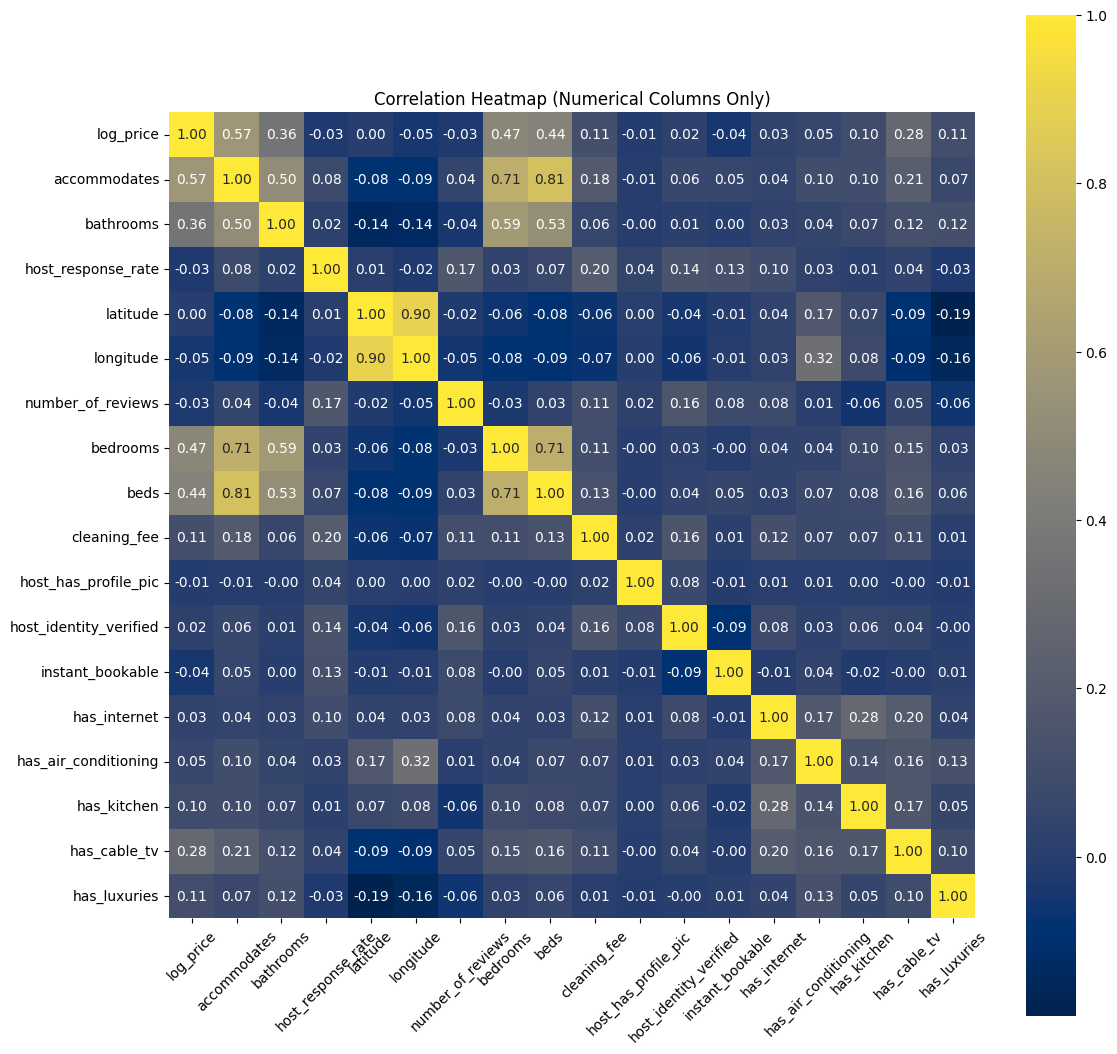

In [71]:
plt.figure(figsize=(13, 13))
sns.heatmap(
    df_non_categorical.corr(), annot=True, cmap="cividis", fmt=".2f", square=True
)
plt.title("Correlation Heatmap (Numerical Columns Only)")
plt.xticks(rotation=45)
plt.show()

#### Insights
+ The amount of people an AirBnb can accommodate is the feature most correlated with the price of an Airbnb.
+ Number of bathrooms, bedrooms, having a TV as well as number of beds, play a significant role of determining the price of an AirBnb.


<ipython-input-72-b520b9fdf7fa>:2: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#2ca02c'` for the same effect.


<ipython-input-72-b520b9fdf7fa>:26: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




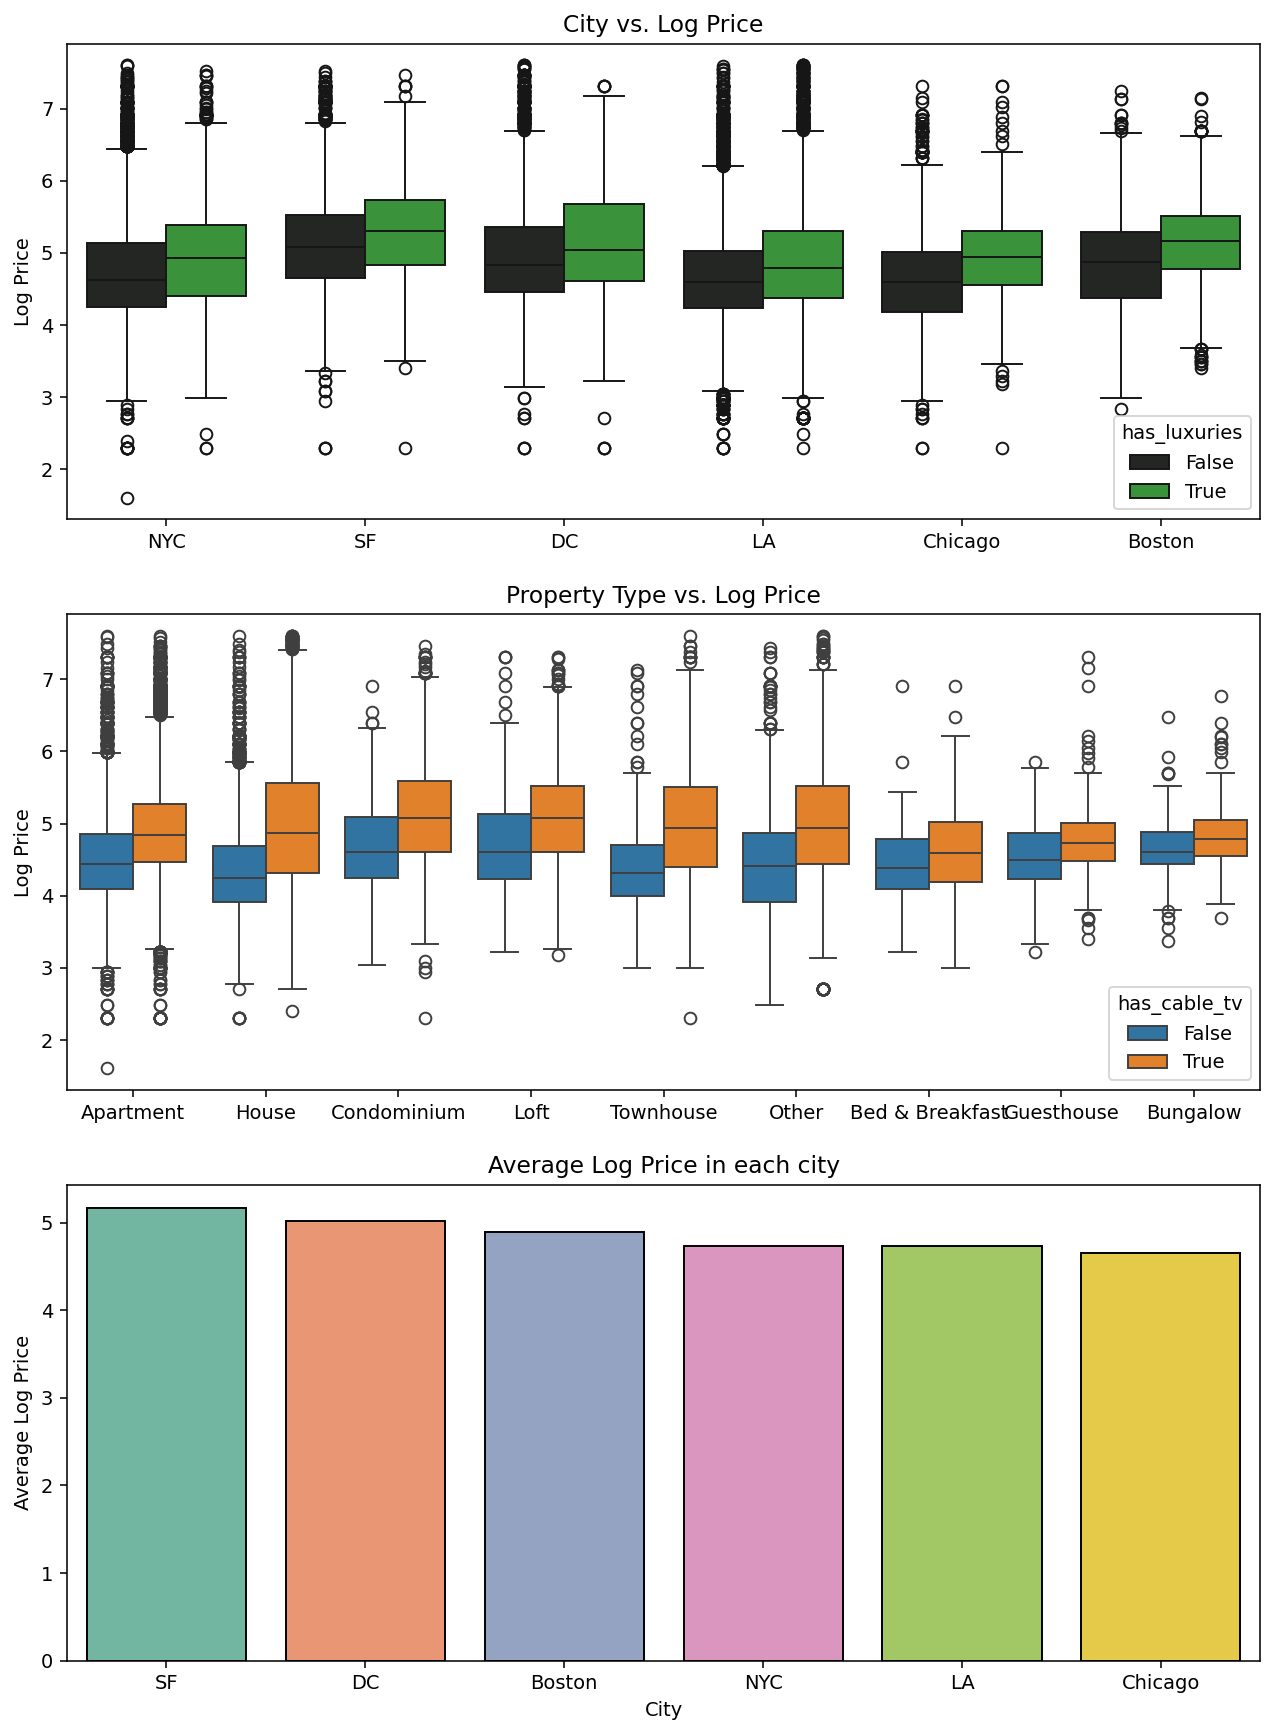

In [72]:
fig, ax = plt.subplots(3, 1, figsize=(11, 15), dpi=140)
sns.boxplot(
    x="city",
    y="log_price",
    data=df,
    hue="has_luxuries",
    ax=ax[0],
    color=sns.color_palette()[2],
)
ax[0].set_title("City vs. Log Price")
ax[0].set_xlabel("")
ax[0].set_ylabel("Log Price")

sns.boxplot(x="property_type", y="log_price", hue="has_cable_tv", data=df, ax=ax[1])
ax[1].set_title("Property Type vs. Log Price")
ax[1].set_xlabel("")
ax[1].set_ylabel("Log Price")


data_city = pd.DataFrame.from_dict(
    dict(df.groupby("city")["log_price"].mean().sort_values(ascending=False)),
    orient="index",
    columns=["log_price"],
)

sns.barplot(
    x=data_city.index,
    y="log_price",
    data=data_city,
    palette="Set2",
    edgecolor="black",
    ax=ax[2],
)

ax[2].set_title("Average Log Price in each city")
ax[2].set_xlabel("City")
ax[2].set_ylabel("Average Log Price")

plt.show()

#### Insights
+ The price of an AirBnb with a TV or luxuries (gym, pool and/or hot tub) is insanely higher than one without
+ Condominums and Lofts appear to be the most expensive property type when renting an Airbnb
+ The highest average price of an AirBnb is in San Fransisco, CA

## Model Training and Optimization

In [73]:
df.drop("name", inplace=True, axis=1)

In [74]:
X = df.drop(["log_price", "amenities"], axis=1)
y = df["log_price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [75]:
CATERGORICAL_COLUMNS = list(df_categorical.columns)
CATERGORICAL_COLUMNS.remove("amenities")
CATERGORICAL_COLUMNS.remove("name")
CATERGORICAL_COLUMNS

['property_type',
 'room_type',
 'bed_type',
 'cancellation_policy',
 'cleaning_fee',
 'city',
 'host_has_profile_pic',
 'host_identity_verified',
 'instant_bookable',
 'neighbourhood',
 'has_internet',
 'has_air_conditioning',
 'has_kitchen',
 'has_cable_tv',
 'has_luxuries']

In [76]:
NUMERICAL_COLUMNS = list(df_numerical.columns)
NUMERICAL_COLUMNS.remove("log_price")
NUMERICAL_COLUMNS

['accommodates',
 'bathrooms',
 'host_response_rate',
 'latitude',
 'longitude',
 'number_of_reviews',
 'bedrooms',
 'beds']

In [77]:
len(NUMERICAL_COLUMNS) + len(CATERGORICAL_COLUMNS)

23

I am caching the best performing models because when hyperparameter tuning is done using ```RandomizedSearchCV()``` is done it will compute faster

In [78]:
numerical_pipeline = make_pipeline(StandardScaler())

catergorical_pipeline = make_pipeline(OneHotEncoder())

full_pipeline = make_column_transformer(
    (numerical_pipeline, NUMERICAL_COLUMNS),
    (catergorical_pipeline, CATERGORICAL_COLUMNS),
)

In [79]:
models = {
    "XGBoost": make_pipeline(full_pipeline, XGBRegressor()),
    "LightGBM": make_pipeline(full_pipeline, LGBMRegressor(verbose=-1, n_jobs=-1)),
    "CatBoost": make_pipeline(
        full_pipeline, CatBoostRegressor(verbose=False), memory="airbnb_model_cache"
    ),
}

model_list = []
model_name_list = []
rmse_list = []


for model_name, model in models.items():
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    r2 = r2_score(y_pred, y_test)
    model_list.append(model)
    model_name_list.append(model_name)
    rmse_list.append(r2)


_ = {"Model Name": model_name_list, "R² Score": rmse_list}

results = pd.DataFrame.from_dict(_).sort_values(by="R² Score", ascending=False)

results

,Model Name,R² Score
2,CatBoost,0.641060
0,XGBoost,0.624721
1,LightGBM,0.616971


I will perform optimization on the best model (```CatBoost```) using ```RandomizedSearchCV()``` so we can achieve a higher R² score

In [80]:
param_grid = {
    "catboostregressor__depth": np.arange(3, 10).tolist(),
    "catboostregressor__l2_leaf_reg": np.arange(2, 10).tolist(),
    "catboostregressor__random_strength": np.arange(0, 10, 2).tolist(),
}

fine_tuned_model = RandomizedSearchCV(
    model_list[2],
    param_grid,
    cv=5,
    n_jobs=-1,
    scoring="r2",
    n_iter=10,
)
fine_tuned_model.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(memory='airbnb_model_cache',
                                      steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['accommodates',
                                                                                'bathrooms',
                                                                                'host_response_rate',
                                                                                'latitude',
                                                                                'longitude',
                                                                                'number_of_reviews',
                                                                                'bedrooms',
                                                                                'beds']),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('onehote...
                                                                                'has_internet',
                                                                                'has_air_conditioning',
                                                                                'has_kitchen',
                                                                                'has_cable_tv',
                                                                                'has_luxuries'])])),
                                             ('catboostregressor',
                                              <catboost.core.CatBoostRegressor object at 0x7e8759ba35e0>)]),
                   n_jobs=-1,
                   param_distributions={'catboostregressor__depth': [3, 4, 5, 6,
                                                                     7, 8, 9],
                                        'catboostregressor__l2_leaf_reg': [2, 3,
                                                                           4, 5,
                                                                           6, 7,
                                                                           8,
                                                                           9],
                                        'catboostregressor__random_strength': [0,
                                                                               2,
                                                                               4,
                                                                               6,
                                                                               8]},
                   scoring='r2')

In [81]:
fine_tuned_model.best_params_

{'catboostregressor__random_strength': 2,
 'catboostregressor__l2_leaf_reg': 5,
 'catboostregressor__depth': 9}

Model Evaluation

In [82]:
y_pred_fine_tuned = fine_tuned_model.predict(X_test)
# y_pred_fine_tuned = airbnb_model.predict(X_test)

In [83]:
r2_fine_tuned = r2_score(y_test, y_pred_fine_tuned) * 100

print(f"R² score:  {r2_fine_tuned}%")

R² score:  73.46509692053982%


In [84]:
scatter_trace = go.Scatter(
    x=y_test,
    y=y_pred_fine_tuned,
    mode="markers",
    name="Actual vs. Predicted",
    line=dict(color="#1f6d8f"),
    showlegend=False,
)

line_trace = go.Scatter(
    x=y_test,
    y=y_test,
    mode="lines",
    name="Regreesion Line",
    showlegend=False,
)

fig = go.Figure()

fig.update_layout(
    title="Tuned CatBoost Regressor (R2 score: {:.2f}%)".format(r2_fine_tuned),
    xaxis_title="Actual Log Price",
    yaxis_title="Predicted Log Price",
    height=900,
    width=900,
)

fig.add_trace(scatter_trace)
fig.add_trace(line_trace)

fig.show()

We were able to improve our model by more than 9%

#### Saving model

In [85]:
joblib.dump(fine_tuned_model, "airbnb_model.pkl")

['airbnb_model.pkl']

In [86]:
airbnb_model = joblib.load("airbnb_model.pkl")